In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import yfinance as yf

from bml.samplers.hmc import DualAveragingHMC
from bml.samplers.nuts import DualAveragingNUTS
from bml.distributions.mvn import MultivariateNormal
from bml.distributions.lr import LogisticRegression
from bml.distributions.hlr import HierarchicalLogisticRegression
from bml.distributions.sv import StochasticVolatility
from bml.distributions.counter import GradCounter


In [2]:
# Configuration
n_runs = 1     
M = 100       
M_adapt = 50

In [3]:
# Set up models
# Multivariate Normal
d = 250 # dimension
theta0_mvn = np.zeros(d)
mvn = MultivariateNormal(d)

# Logistic Regression
# Fetch the German Credit (numeric) dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric"
data = pd.read_csv(url, sep=r'\s+', header=None)
X_raw = data.iloc[:, :-1].values
y_raw = data.iloc[:, -1].values
y = np.where(y_raw == 1, 1, -1)
X_norm = (X_raw - np.mean(X_raw, axis=0)) / np.std(X_raw, axis=0)
X = np.hstack([np.ones((X_norm.shape[0], 1)), X_norm])
d = X.shape[1]
sigma_sq = 100.0
theta0_lr = np.zeros(d)
lr = LogisticRegression(X, y, sigma_sq)

# Hierarchical Logistic Regression
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_expanded = poly.fit_transform(X_norm)
X = np.hstack([np.ones((X_expanded.shape[0], 1)), X_expanded])
N, d_coeffs = X.shape  # N=1000, d_coeffs=301 (alpha + 300 beta coefficients)
lam = 0.01 # Rate parameter for the exponential prior on sigma^2
d = d_coeffs + 1
theta0_hlr = np.zeros(d)
theta0_hlr[-1] = np.log(100.0) 
hlr = HierarchicalLogisticRegression(X, y, N, d_coeffs, lam)

# Stochastic Volatility
sp500 = yf.download('^GSPC', start='1995-01-01', end='2010-01-01', progress=True, auto_adjust=False)
prices = sp500['Adj Close'].values.flatten()
returns = np.diff(np.log(prices))
R = returns[-3000:]
N_days = len(R) # 3000
d = N_days + 1  # 3001 parameters
theta0_sv = np.zeros(d)
theta0_sv[:-1] = np.log(np.std(R)) 
theta0_sv[-1] = np.log(10.0)
sv = StochasticVolatility(R)

[*********************100%***********************]  1 of 1 completed


In [4]:
models_config = {
    "Multivariate Normal": {"dist": mvn, "theta0": theta0_mvn},
    "Logistic Regression": {"dist": lr, "theta0": theta0_lr},
    "Hierarchical Logistic Regression": {"dist": hlr, "theta0": theta0_hlr},
    "Stochastic Volatility": {"dist": sv, "theta0": theta0_sv}
}

In [5]:
# Values for the Target Acceptance Rate (delta) from the paper
deltas_nuts = np.linspace(0.25, 0.95, 15)
deltas_hmc = np.linspace(0.25, 0.95, 8)

# Specific HMC lambda values plotted in Figure 3
hmc_lambdas = {
    "Multivariate Normal": [1.5, 3.4, 7.8, 18, 40],
    "Logistic Regression": [0.075, 0.17, 0.39, 0.88, 2],
    "Hierarchical Logistic Regression": [0.044, 0.097, 0.21, 0.46, 1],
    "Stochastic Volatility": [0.15, 0.34, 0.78, 1.8, 4]
}

In [6]:
results = []

for model_name, config in models_config.items():
    print(f"\nRunning {model_name}")
    dist = config["dist"]
    theta0 = config["theta0"]
    
    print("Running NUTS...")
    sampler_nuts = DualAveragingNUTS(L=dist.log_p, grad=dist.grad_log_p)
    for delta in deltas_nuts:
        for run in range(n_runs):
            _, stats = sampler_nuts.sample(theta0, delta=delta, M=M, M_adapt=M_adapt)
            
            h_realized = np.mean(stats['h_stat'][M_adapt:])
            results.append({
                "Model": model_name, "Sampler": "NUTS", "Lambda": None,
                "Delta": delta, "h_minus_delta": h_realized - delta, "Run": run
            })
            
    print("Running HMC...")
    # Use the safe version of HMC to prevent excessively long trajectories
    sampler_hmc = DualAveragingHMC(L=dist.log_p, grad=dist.grad_log_p, safe=True)
    for lam in hmc_lambdas[model_name]:
        print(f"Lambda={lam}")
        for delta in deltas_hmc:
            for run in range(n_runs):
                _, stats = sampler_hmc.sample(theta0, delta=delta, lam=lam, M=M, M_adapt=M_adapt)
                
                h_realized = np.mean(stats['h_stat'][M_adapt:])
                col_name = f"HMC $\\epsilon L={lam}$"
                results.append({
                    "Model": model_name, "Sampler": col_name, "Lambda": lam,
                    "Delta": delta, "h_minus_delta": h_realized - delta, "Run": run
                })


Running Multivariate Normal
Running NUTS...
Running HMC...
Lambda=1.5
Lambda=3.4
Lambda=7.8
Lambda=18


C:\Users\adoni\Desktop\Bayesian Machine Learning\MVA-BML\src\bml\distributions\mvn.py:11: RuntimeWarning: overflow encountered in dot
  return -0.5 * np.dot(theta, np.dot(self.A, theta))
C:\Users\adoni\Desktop\Bayesian Machine Learning\MVA-BML\src\bml\samplers\hmc.py:43: RuntimeWarning: overflow encountered in dot
  log_ratio = (self.L(theta_tilde) - 0.5 * np.dot(r_tilde, r_tilde)) - (self.L(theta_prev) - 0.5 * np.dot(r0, r0))


Lambda=40


C:\Users\adoni\Desktop\Bayesian Machine Learning\MVA-BML\src\bml\distributions\mvn.py:14: RuntimeWarning: overflow encountered in dot
  return -np.dot(self.A, theta)
C:\Users\adoni\Desktop\Bayesian Machine Learning\MVA-BML\src\bml\distributions\mvn.py:14: RuntimeWarning: invalid value encountered in dot
  return -np.dot(self.A, theta)
C:\Users\adoni\Desktop\Bayesian Machine Learning\MVA-BML\src\bml\samplers\utils.py:13: RuntimeWarning: invalid value encountered in add
  r_tilde = r_tilde + (epsilon / 2) * grad(theta_tilde)
C:\Users\adoni\Desktop\Bayesian Machine Learning\MVA-BML\src\bml\distributions\mvn.py:11: RuntimeWarning: invalid value encountered in dot
  return -0.5 * np.dot(theta, np.dot(self.A, theta))



Running Logistic Regression
Running NUTS...
Running HMC...
Lambda=0.075
Lambda=0.17
Lambda=0.39
Lambda=0.88
Lambda=2

Running Hierarchical Logistic Regression
Running NUTS...


C:\Users\adoni\Desktop\Bayesian Machine Learning\MVA-BML\src\bml\samplers\nuts.py:185: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(joint_prob - joint_prob0))


Running HMC...
Lambda=0.044
Lambda=0.097
Lambda=0.21
Lambda=0.46
Lambda=1

Running Stochastic Volatility
Running NUTS...
Running HMC...
Lambda=0.15
Lambda=0.34
Lambda=0.78
Lambda=1.8
Lambda=4


In [8]:
df = pd.DataFrame(results)

In [10]:
df.to_csv("../results/discrepancies.csv", index=False)

In [11]:
df

,Model,Sampler,Lambda,Delta,h_minus_delta,Run
0,Multivariate Normal,NUTS,NaN,0.25,-0.247166,0
1,Multivariate Normal,NUTS,NaN,0.30,-0.144571,0
2,Multivariate Normal,NUTS,NaN,0.35,-0.213076,0
3,Multivariate Normal,NUTS,NaN,0.40,-0.323742,0
4,Multivariate Normal,NUTS,NaN,0.45,0.069847,0
...,...,...,...,...,...,...
215,Stochastic Volatility,HMC $\epsilon L=4$,4.0,0.55,-0.530008,0
216,Stochastic Volatility,HMC $\epsilon L=4$,4.0,0.65,-0.473958,0
217,Stochastic Volatility,HMC $\epsilon L=4$,4.0,0.75,-0.750000,0
218,Stochastic Volatility,HMC $\epsilon L=4$,4.0,0.85,-0.616783,0


C:\Users\adoni\AppData\Local\Temp\ipykernel_19976\4211879505.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(pad=1.5)


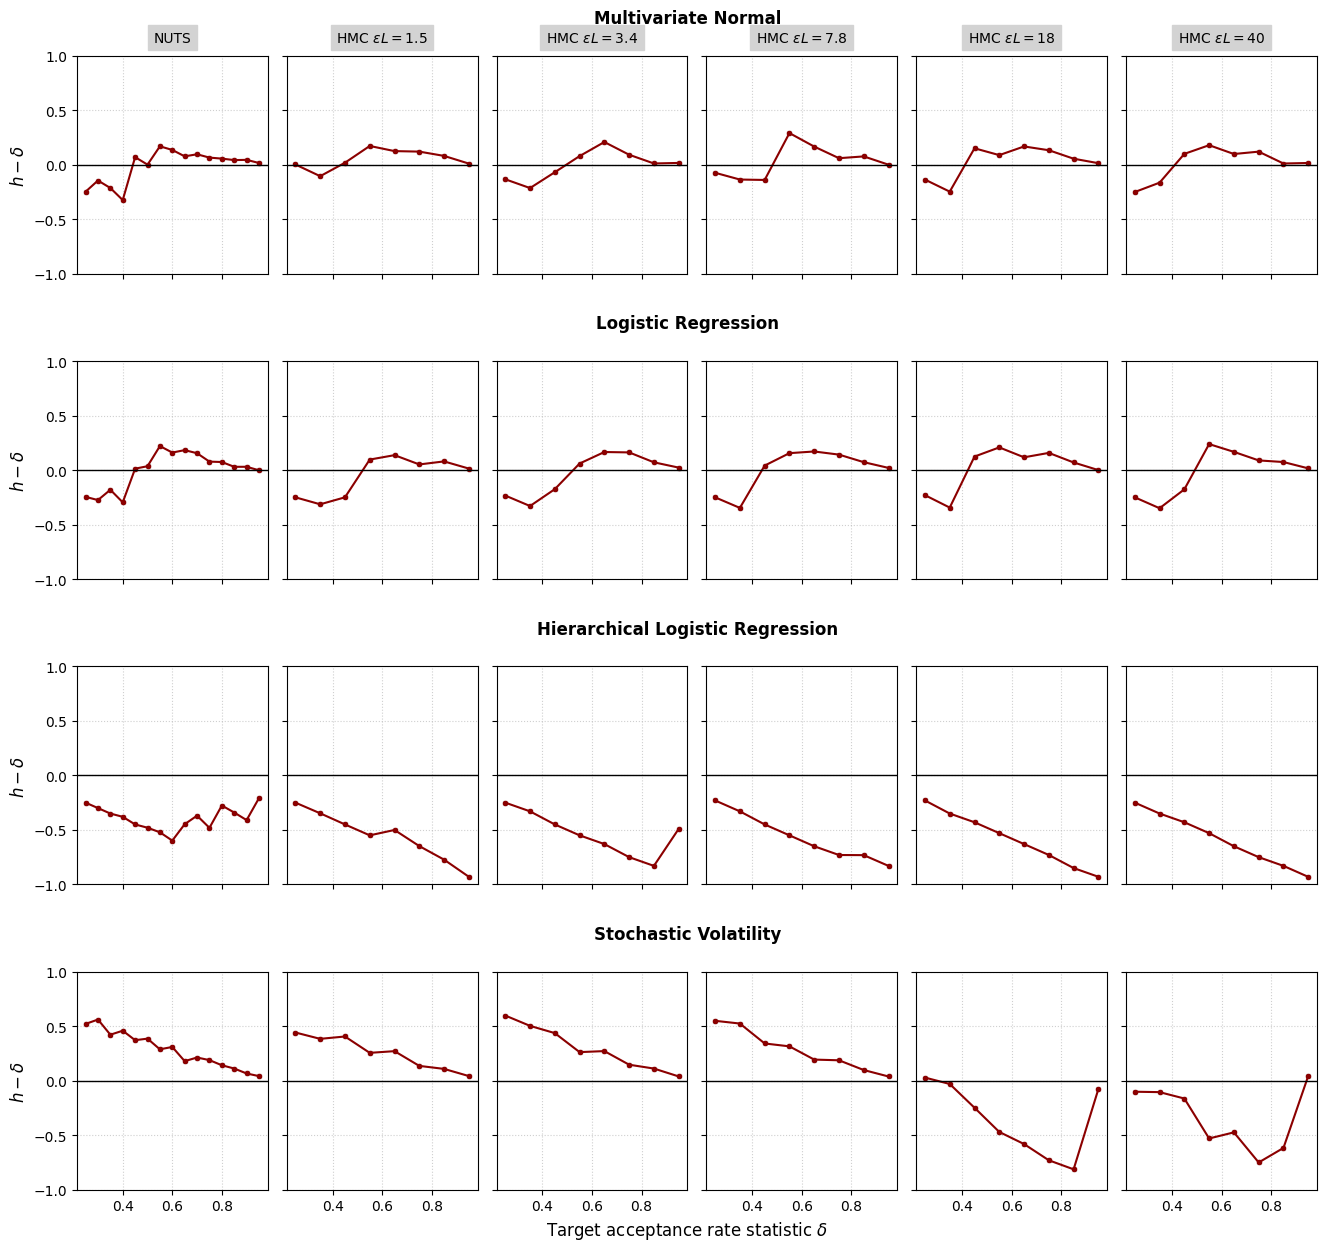

In [23]:
model_order = ["Multivariate Normal", "Logistic Regression", "Hierarchical Logistic Regression", "Stochastic Volatility"]

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 14), sharex=True, sharey=True)

for i, model_name in enumerate(model_order):
    model_data = df[df["Model"] == model_name]
    
    # Organize columns (NUTS first, then HMC in increasing lambda order)
    lambdas = hmc_lambdas[model_name]
    cols = ["NUTS"] + [f"HMC $\\epsilon L={lam}$" for lam in lambdas]
    
    # Add model title slightly above each row
    axes[i, 0].annotate(model_name, xy=(3.2, 1.15), xycoords='axes fraction', 
                        ha='center', fontsize=12, fontweight='bold')
    
    axes[i, 0].set_ylabel(r"$h - \delta$", fontsize=12)
    
    for j, sampler_col in enumerate(cols):
        ax = axes[i, j]
        cell_data = model_data[model_data["Sampler"] == sampler_col]
        
        # Plot individual run points (grey crosses)
        ax.scatter(cell_data["Delta"], cell_data["h_minus_delta"], 
                   color='grey', alpha=0.5, s=10, marker='x')
        
        # Plot the average across runs with a solid line
        avg_data = cell_data.groupby("Delta")["h_minus_delta"].mean().reset_index()
        ax.plot(avg_data["Delta"], avg_data["h_minus_delta"], 
                color='darkred', marker='o', markersize=3, linestyle='-')
        
        # Format axes
        ax.axhline(0, color='black', linewidth=1)
        ax.set_ylim(-1.0, 1.0)
        ax.set_xticks([0.4, 0.6, 0.8])
        ax.grid(True, linestyle=':', alpha=0.6)
        
        # Set titles for the top row to identify samplers
        if i == 0:
            if j == 0:
                ax.set_title("NUTS", fontsize=10, backgroundcolor='lightgrey', pad=10)
            else:
                ax.set_title(cols[j], fontsize=10, backgroundcolor='lightgrey', pad=10)
        
        # X-axis label only on the bottom row, center
        if i == 3 and j == 2:
            ax.set_xlabel(r"Target acceptance rate statistic $\delta$", fontsize=12, x=1.0)

plt.tight_layout(pad=1.5)
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.1)
plt.savefig("../results/discrepancies_plot.png", dpi=300)